In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F
from sklearn.metrics import mean_absolute_error
import sklearn
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id
import re
from collections import Counter


# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/10 03:56:09 WARN Utils: Your hostname, DESKTOP-JJJD94T resolves to a loopback address: 127.0.1.1; using 172.29.75.144 instead (on interface eth0)
22/10/10 03:56:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 03:56:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/10 03:56:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Summary

### Introduction

Buy Now Pay Later (BNPL) services are a popular method of financing that allows consumers to make purchases and pay for them at a later date. Users pay off what is owed through interest free timely installments and don't have to worry about having the given funds at the time of purchase. Your BNPL firm has recently started their own “pay in 5 installments plan” and is only able to onboard 100 merchants every year for their plan due to limited resources. Choosing 100 merchants at random could cost the company millions of dollars in revenue down the line so it is vital to choose the top 100 merchants available to maximize profits. This is no easy task however and that is where I and my team come in. I’m Aryan Shahi, this is Jai Bretherton, this is Eesha Syed, and this is Minma Herath. We are all bachelor of science students at the University of Melbourne who are majoring in data science and we all accepted to offer our experience to help solve this problem. Our task was to determine the top 100 merchants to be selected by the firm based on given and external data.

### Datasets

##### Given

In [2]:
merchantdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
userdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
transactiondf = spark.read.parquet("../data/curated/transactiondf.parquet/")
consumerdf = spark.read.option("header","true").csv("../data/tables/tbl_consumer.csv", sep="|")
consumerfrauddf = spark.read.parquet("../data/curated/consumerfrauddf.parquet/")
merchantfrauddf = spark.read.parquet("../data/curated/merchantfrauddf.parquet/")

In [3]:
merchantdf.limit(3)

company_name,tags,merchant_abn,take_rate,revenue_band
Felis Limited,"furniture, home f...",10023283211,0.18,e
Arcu Ac Orci Corp...,"cable, satellite,...",10142254217,4.22,b
Nunc Sed Company,"jewelry, watch, c...",10165489824,4.40,b


In [4]:
userdf.limit(3)

user_id,consumer_id
1,1195503
2,179208
3,1194530


In [5]:
transactiondf.limit(3)

user_id,merchant_abn,dollar_value,order_id,order_datetime
14935,79417999332,136.06570809815838,23acbb7b-cf98-458...,2021-11-26
1,46451548968,72.61581642788431,76bab304-fa2d-400...,2021-11-26
14936,89518629617,3.0783487174439297,a2ae446a-2959-41c...,2021-11-26


In [6]:
consumerdf.limit(3)

name,address,state,postcode,gender,consumer_id
Yolanda Williams,413 Haney Gardens...,WA,6935,Female,1195503
Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530


In [7]:
consumerfrauddf.limit(3)

user_id,order_datetime,fraud_probability
3753,2022-02-16,48.85325253622543
9646,2021-09-23,47.83931206340956
243,2021-09-02,50.88971939168309


In [8]:
merchantfrauddf.limit(3)

merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095


##### External

In [9]:
populationdf = pd.read_excel("../data/tables/population.xlsx", sheet_name = 'Table 3', skiprows = 7)
incomedf = spark.read.option("header","false").csv("../data/tables/datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_personal_income_total_income_sa2_2011_2018.csv")
postcodedf = spark.read.option("header","true").csv("../data/tables/australian_postcodes.csv")
postcode_ratio_df = pd .read_excel("../data/tables/1270055006_CG_POSTCODE_2011_SA2_2011.xls",sheet_name = 'Table 3',skiprows = 5)

In [10]:
populationdf.head(3)

,S/T code,S/T name,GCCSA code,GCCSA name,SA4 code,SA4 name,SA3 code,SA3 name,SA2 code,SA2 name,...,no..9,no..10,no..11,no..12,no..13,no..14,no..15,no..16,no..17,no..18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,New South Wales,1RNSW,Rest of NSW,101.0,Capital Region,10102.0,Queanbeyan,101021007.0,Braidwood,...,300.0,352.0,362.0,424.0,328.0,293.0,237.0,123.0,82.0,4330.0
2,1,New South Wales,1RNSW,Rest of NSW,101.0,Capital Region,10102.0,Queanbeyan,101021008.0,Karabar,...,556.0,590.0,580.0,516.0,412.0,320.0,216.0,159.0,90.0,8546.0


In [11]:
incomedf.limit(3)

22/10/10 03:56:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39
FID,fid,sa2_code,sa2_name,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,sum_aud_2011_12,sum_aud_2012_13,sum_aud_2013_14,sum_aud_2014_15,sum_aud_2015_16,sum_aud_2016_17,sum_aud_2017_18,median_aud_2011_12,median_aud_2012_13,median_aud_2013_14,median_aud_2014_15,median_aud_2015_16,median_aud_2016_17,median_aud_2017_18,mean_aud_2011_12,mean_aud_2012_13,mean_aud_2013_14,mean_aud_2014_15,mean_aud_2015_16,mean_aud_2016_17,mean_aud_2017_18,wkb_geometry
abs_personal_inco...,74,103031075,Wollangambe - Wol...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,MULTIPOLYGON (((-...
abs_personal_inco...,131,107011133,Port Kembla Indus...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,MULTIPOLYGON (((-...


In [12]:
postcodedf.limit(3)

id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region,Lat_precise,Long_precise,SA1_MAINCODE_2011,SA1_MAINCODE_2016,SA2_MAINCODE_2016,SA2_NAME_2016,SA3_CODE_2016,SA3_NAME_2016,SA4_CODE_2016,SA4_NAME_2016,RA_2011,RA_2016,MMM_2015,MMM_2019,ced,altitude,chargezone,phn_code,phn_name,lgaregion,electorate,electoraterating
230,0200,ANU,ACT,149.119,-35.2777,null,null,null,null,null,null,null,R1,-35.2777,149.119,80105104901,80105104901,801051049,Acton,80105,North Canberra,801,Australian Capita...,1,1,1,1,null,null,N2,null,null,null,Durack,null
21820,0200,Australian Nation...,ACT,149.1189,-35.2777,null,null,Added 19-Jan-2020,null,null,null,null,R1,-35.2776999,149.118527,80105104901,80105104901,801051049,Acton,80105,North Canberra,801,Australian Capita...,1,1,1,1,null,null,N2,null,null,null,Durack,null
232,0800,DARWIN,NT,130.83668,-12.458684,null,null,Updated 6-Feb-2020,70101,Darwin City,701,Darwin,R1,-12.3932794,130.7766611,70101100203,70101100218,701011002,Darwin City,70101,Darwin City,701,Darwin,3,3,2,2,null,null,NT1,PHN701,Northern Territory,Darwin,Solomon,Inner Metropolitan


In [13]:
postcode_ratio_df.head(3)

,POSTCODE,POSTCODE.1,SA2_MAINCODE_2011,SA2_NAME_2011,RATIO,PERCENTAGE
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0800,800.0,701011002.0,Darwin City,1.000000,99.999998
2,0810,810.0,701021010.0,Alawa,0.071997,7.199707


The datasets we were given included user data, fraud data, consumer data, merchant data, and 3 batches of transactional data. The transactional datasets when combined had a total of 1.42 million rows with each row representing a transaction and containing features such as the amount, the datetime, and the merchant/user involved. The user dataset had 499,999 rows with each row representing a user and the features included were user id and consumer id. It was used to join with the consumer dataset which also contained 499,999 rows with each row representing a consumer but had useful features such as the consumers gender, and address. The term consumer and user will be used interchangeably throughout this presentation but will refer to the same thing, a person that is involved in a transaction with any merchant. <br>
The fraud data came from 2 datasets, one for user fraud and the other for merchant fraud. Both had the same features including id, the datetime, and the fraud probability with each row respectively representing a particular user or merchant at a given datetime. The merchant fraud dataset contained 114 rows whilst the consumer fraud dataset contained 34,864 rows. The final dataset we were given was the merchant data where each of the 4026 rows represented the information for a given merchant with the columns being merchant abn, the company name, and their respective tags.
<br>
3 external datasets were also used, the first of which was SA2 population data containing population numbers for each SA2 code. The second dataset was income data by SA2 region. It was obtained from the Australian Bureau of Statistics (ABS) website and consisted of 2289 rows with each row representing a SA2 region and its respective statistics such as income earned and the demographics of the people that earned it for each year starting from 2011 and ending in 2018. The final external dataset used was the postcode and SA2 dataset which allowed for the joining of given and external datasets.

In [14]:
futureuserfrauddf = spark.read.parquet("../data/curated/future_user_fraud.parquet")
futuremerchantfrauddf = spark.read.parquet("../data/curated/future_merchant_fraud.parquet")

In [15]:
futureuserfrauddf.limit(3)

user_id,max_amount,max_transactions,transaction_std,amount_sd
19979,8150.115728134807,9,0.84476618165645,400.16781038916344
23492,4097.470542751887,9,0.8232347161406164,294.7157993790497
12568,2042.0161577505257,8,0.8757538133134091,239.94494399815406


In [16]:
futuremerchantfrauddf.limit(3)

merchant_abn,max_amount,max_transactions,transaction_sd,amount_sd
83412691377,201.92111142420248,57,6.1317702357686885,24.483086120347327
73256306726,2074.313458274829,26,3.2774277009648425,230.49860679672886
38700038932,5444.634544750903,23,3.558872805885871,713.0931587735073


### Pre Processing and Outlier Analysis

For the datasets provided, the majority of fields contained valid entries for all transactions and no preprocessing was required. One problematic field however was the dollar amount of transactions, as some transactions were found to have clearly nonsensical dollar values, such as less than a cent. Since we are not given information about the product range of these merchants, we made the safe assumption that a transaction needed a dollar value higher than a cent to be considered valid.
<br>
Outside of this, the only field that required significant preprocessing was the tags field located in the merchant data. This field in fact contained 3 separate pieces of important information: a category for the merchant, a label indicating their revenue band on a scale from a-e, as well as their negotiated take rate with the BNPL firm. This field was therefore split into 3 separate columns.
<br>


The population dataset contained, for each SA2 code, the total population and the population of each age group in intervals of 4, example: 0-4, 5-9, 10-14, etc.. Because these age groups alone don’t have much meaning, custom age groups were created: under 10, adolescent (aged 10-17), young adult (18-34), middle age (35-59), and old (60+). The age ranges selected for these age groups were based on similar popular age groups globally defined and noting the fact that the average retirement age in Australia is 65.
<br>
Using these age groups, it was found that their distribution was almost the same on the state and territory level (show pie charts), with the middle age population being the most dominant followed by old and young adults, except in the territories where the young adults population was larger than old population. Then came the adolescent and under 10 population which had minor differences in their distribution.
<br>
It was found that a total of 38 SA2 regions had a population of zero. Upon closer inspection, these regions were places such as airports, creeks, and other ‘green’ uninhabitable places. On the opposite end, for a large population of young adults, it was found that these places were cities or near the cities. Another find was that there were some places populated entirely by either young adults, middle aged, or old people. Upon analyzing further, the total population of each of these regions was less than or equal to 10, which makes the find understandable.
<br>

An obstacle we faced was the fact that our given data was postcode-based and external data (population and income) was SA2 based. Hence, we needed data that would correspond each postcode to SA2 codes. We found 2 such datasets, however, as a postcode region is larger than a SA2 region, one postcode can have many SA2 codes. So how to accurately assign our external data to our existing data?
<br>
One of our postcode datasets contained ratio, i.e. how the population of a postcode is distributed amongst the SA2 codes. So we could use weighted averaging as opposed to just averaging to get a single value from population/income data for each postcode. However, the postcode ratio dataset contained less correspondences than our postcode dataset without ratio, which would lead to more loss of records when joining, almost 1.5 million to be exact. Hence, we decided that the weighted averaging provided by the postcode ratio dataset would not be worth the loss of these many records. After combining our given data with external data, we had a total of 11,818,811 records.
<br>

The income dataset contained the same few columns for each year ranging from 2011 to 2018. Seeing as the transaction data started from 2021 we removed all columns 2017 and below to get the latest SA2 income data available. Useless columns such as sum of everyone's income were removed and that left us with 5 columns which included SA2 code, number of earners, median age of earners, median income, and mean income. Distributions were made for each feature to see how they varied for the different SA2 regions and based on them only 50 rows were removed. 48 of these were removed because the entire row was filled with nulls and the other 2 were removed because they had implausible median ages. This brought the final dataset down to 2239 entries.
<br>

When inner joining all the given data, the only decrease in the number of rows was when there was a join with the merchants dataframe. The number of rows decreased from 14.1 million to 13.6 million because the merchants dataframe didn’t have the abn’s of some of the merchants that were showing up in the transactional data. When inner joining with external datasets the number of rows lost were 1.8 million because of SA2 mismatches and rows containing null values for all columns. This meant our final dataset consisted of 11.8 million rows.
<br>


We were given two sets of fraud data one for consumer fraud and the other for merchant fraud. We decided to set the threshold to 1% so anything above 1% would be considered fraud and that way we could be confident that all the fraud transactions had been removed. Since the minimum user fraud was 8 percent and the minimum merchant fraud was 18% this meant that all fraud transactions got removed. This only removed 60 thousand rows which was only 0.005% of the overall data so nothing major had been lost, but removing this fraud meant that we were left with transactions that only had 0.01% fraud chance which meant they were almost guaranteed to be accurate. This allowed us to create distributions for both merchants and users in terms of total transactions and total money spent/made in a day which will allow us to predict future fraud. If a user or merchant has 1.5 times their standard deviation in the number of transactions or transaction amounts in a day then they will be considered fraud. It was interesting to find that there were also some duplicate entries in the user fraud dataset.
<br>

This gave us our final dataset to be used in modelling and thus ranking:

In [17]:
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2022-07-13,49891706470,22131,6731,58911,25.782245737474312,90498b80-984f-43c...,WA,Male,Non Vestibulum In...,tent and awning s...,5.80,a,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2021-08-19,96680767841,22131,6731,58911,415.9547984625,829843bc-c571-493...,WA,Male,Ornare Limited,motor vehicle sup...,5.91,a,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2022-07-13,43186523025,22131,6731,58911,33.082322196774484,c12d2520-12c8-40f...,WA,Male,Lorem Ipsum Sodal...,florists supplies...,4.47,b,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2021-08-19,66370248931,22131,6731,58911,82.54046571771035,cc8ac5c5-0dfc-4e1...,WA,Male,Morbi Non PC,"cable, satellite,...",3.15,b,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2022-05-06,89726005175,22131,6731,58911,58.46693553052902,b1f179f8-2c15-4f5...,WA,Male,Est Nunc Consulting,tent and awning s...,6.01,a,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1


### Modelling

One of our very first ideas we had for the modeling and ranking of merchants was to simply onboard the merchants that had generated the most overall revenue. 

In [18]:
modeldf1 = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf1 = modeldf1.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf1 = modeldf1.withColumn('profit', round(finaldf.dollar_value * (finaldf.take_rate / 100), 2))

for field in ("postcode","take_rate"):
    modeldf1 = modeldf1.withColumn(
        field,
        col(field).cast('double')
    )

modeldf1 = modeldf1.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf1 = modeldf1.groupBy("year","month","merchant_abn").agg(
    round(sum("profit"),2).alias("monthly_profit"),
)
modeldf1.limit(3)

year,month,merchant_abn,monthly_profit
2022,5,77338620996,10072.1
2021,11,11700214701,3166.25
2022,7,34179569263,18195.89


However, what we as a group realised is that a simple model such as this would be making the rather significant assumption that once a merchant is onboarded by the firm, every single transaction made with that merchant would now be made with the BNPL technology, which clearly isn’t a very realistic assumption.
 
So to improve on this idea, we decided we would still create this model, but we would also build 2 additional models. In order to determine these other features, we reviewed surveys from [C+R research](https://www.crresearch.com/blog/buy_now_pay_later_statistics) as well as [Bankrate](https://www.bankrate.com/loans/personal-loans/buy-now-pay-later-statistics/) regarding BNPL usage statistics. Some interesting statistics we found was that only 3% of respondents owed over $2 500 currently to BNPL services, and this debt was owed across an average of 3.8 different purchased items. Considering that under the current structure, consumers would only be able to pay back items in exactly 5 installments, we determined that there was likely to be a limit as to how much people would spend in a single BNPL transaction, and hence we would prefer merchants who not only generated large revenue, but did so through many smaller value transactions vs fewer larger transactions. This was the motivation behind our second model being based around the number of transactions for a given merchant.

In [19]:
modeldf2 = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf2 = modeldf2.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))

for field in ("postcode","take_rate"):
    modeldf2 = modeldf2.withColumn(
        field,
        col(field).cast('double')
    )

modeldf2 = modeldf2.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf2 = modeldf2.groupBy("year","month","merchant_abn").agg(
    count("dollar_value").alias("monthly_transactions"),
)

modeldf2.limit(5)

year,month,merchant_abn,monthly_transactions
2022,5,77338620996,575
2021,11,11700214701,84
2022,7,34179569263,1083
2021,12,36800720158,86
2021,10,24852446429,12696


However, by similar logic, we should also prefer merchants with a wider consumer base, or a merchant that makes a large amount of revenue, from frequent, smaller value transactions that are likely to be from different customers. So while having our third model be based on the number of unique customers for a merchant would be justified, another interesting fact that we found was that amongst certain predefined income ranges, the highest proportion of BNPL users came from the group with average household income between \\$50 000-\\$75 000. Combining these two ideas led to our final model, which was based on the number of unique customers for a given merchant who resides in a postcode with median income between \\$50 000 and \\$75 000.

In [20]:
LOWER_INCOME_THRESHOLD = 50000
UPPER_INCOME_THRESHOLD = 75000
modeldf3 = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf3 = modeldf3.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf3 = modeldf3.filter((modeldf3.median_income > LOWER_INCOME_THRESHOLD) &
                         (modeldf3.median_income < UPPER_INCOME_THRESHOLD))
                                     
for field in ("postcode","take_rate"):
    modeldf3 = modeldf3.withColumn(
        field,
        col(field).cast('double')
    )

modeldf3 = modeldf3.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")
modeldf3 = modeldf3.groupBy("year","month","merchant_abn").agg(
    countDistinct("consumer_id").alias("monthly_middle_customers"),
)
modeldf3

year,month,merchant_abn,monthly_middle_customers
2021,11,53655334735,7
2021,3,33163130598,34
2022,4,16165222459,27
2022,5,60956456424,1107
2022,5,82539239304,24
2021,10,24852446429,2818
2022,9,46987545043,245
2022,4,52160665475,162
2022,5,94472466107,300
2021,5,80779820715,395


Additionally, to improve these ideas further, rather than just derive statistics such as overall revenue based on the previous transactions seen in the data, we aimed to identify any potential trends in these statistics for merchants, and hence use these trends to try and predict, for example the future revenue, of every merchant in every month of 2023. 
 
Such predictions were done through the use of a simple time series regression model, which is essentially just a typical linear regression model, but with the addition of what are called lagged variables. To take the example of our model to predict future revenue, the lagged variables in this time series regression would be the predicted revenue of the merchant for the previous certain amount of months. 

In [21]:
dfp = spark.read.parquet("../data/curated/trans_num_predictions.parquet").toPandas()
print(dfp)
print(mean_absolute_error(dfp["monthly_transactions"],  dfp["prediction"]))

       merchant_abn  int_month  monthly_transactions  merchant_abn_class  \
0       10023283211         19                   146                 0.0   
1       10023283211         20                   173                 0.0   
2       10023283211         21                   164                 0.0   
3       10142254217         19                   149                 1.0   
4       10142254217         20                   130                 1.0   
...             ...        ...                   ...                 ...   
12049   99987905597         20                    15              4016.0   
12050   99987905597         21                     8              4016.0   
12051   99990536339         19                     2              4017.0   
12052   99990536339         20                     1              4017.0   
12053   99990536339         21                     1              4017.0   

                                        merchant_abn_ohe  \
0      (1.0, 0.0, 0.0, 0.0,

In [22]:
dfp = spark.read.parquet("../data/curated/profit_merch_predictions.parquet").toPandas()
print(dfp)
print(mean_absolute_error(dfp["monthly_transactions"],  dfp["prediction"]))

AnalysisException: Path does not exist: file:/mnt/c/Users/Eesha/Desktop/GitHub/project2/generic-buy-now-pay-later-project-group-35/data/curated/profit_merch_predictions.parquet

In [ ]:
dfp = pd.read.parquet("../data/curated/medium_customers_predictions.parquet").toPandas()
print(dfp)
print(mean_absolute_error(dfp["monthly_transactions"],  dfp["prediction"]))

This leaves the important question of how many months should we use to predict the next month’s value? On one hand, having more lags means a smaller sample size of months to build our model on, as for example, the month of February 2021 doesn’t have any data from a previous month to use as a feature, meaning it is of no use to us. And so the more lags we add, the more months we discard. However, on the other hand, more lags means our model can more accurately predict certain trends over time. Extended analysis (see appropriate notebooks for further analysis) determined that for a large majority of merchants, two lags was seen as being the best of both worlds.

### Results

#### Initial Ranking System

Ranking System uses the following features:
- future predictions for transactions per merchant per month
- future predictions for profit per merchant per month
- future predictions for customers within revenue range \\$50k-\\$75k per month
- population (quartiles) of young adults and middle aged adults based on postcodes of consumers

In [23]:
# change this when above code is working

future_trans_sdf = spark.read.parquet("../data/curated/futuretrans.parquet/")
future_profit_sdf = spark.read.parquet("../data/curated/futureprofit.parquet/")
future_mcustomers_sdf = spark.read.parquet("../data/curated/futuremcustomers.parquet/")
merch_pop = spark.read.parquet("../data/curated/merch_pop.parquet/")

Create a pandas dataframe to store points for each merchant, with total points initialized to zero.

In [24]:
merchants_rank = future_trans_sdf \
    .select('merchant_abn') \
    .distinct() \
    .withColumns({
        'total_points': lit(1),
        'pop_points': lit(0),
        'trans_points': lit(0),
        'profit_points': lit(0),
        'mcust_points': lit(0)
    }) \
    .orderBy("merchant_abn") \
    .toPandas()

merchants_rank

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,1,0,0,0,0
1,10142254217,1,0,0,0,0
2,10165489824,1,0,0,0,0
3,10187291046,1,0,0,0,0
4,10192359162,1,0,0,0,0
...,...,...,...,...,...,...
4013,99938978285,1,0,0,0,0
4014,99974311662,1,0,0,0,0
4015,99976658299,1,0,0,0,0
4016,99987905597,1,0,0,0,0


Have 4018 distinct merchants, need to select top 100 merchants

Idea:
- all merchants have initial points 1
- the more the number of points, the higher/better the rank will be
- points given based on sorted positioning within the features and importance of the feature (for transaction, profit, and mcustomers)
- award 0.125 points to merchants having a relatively large young adult and middle age population (external research) <br>
with large meaning the populations are above the lower quartile (not group 1 - see notebook 4.4)
- each feature has a weight to assign importance, with all weights summing to 1

In [25]:
WEIGHT_POP = 0.125
WEIGHT_TRANS = 0.375
WEIGHT_PROFIT = 0.375
WEIGHT_MCUSTOMERS = 0.125

#### Population points

In [26]:
w = Window.partitionBy('month')

merch_pop_mod = merch_pop \
    .drop(*("total_pop", "under10_pop", "adolsc_pop", "old_pop")) \
    .withColumn(
        "points",
        when(
            (col("yng_adult_pop") != 1) &
            (col("mid_age_pop") != 1),
            lit(0.125)
        ).otherwise(lit(0))
    ) \
    .drop(*("yng_adult_pop", "mid_age_pop")) \
    .orderBy("merchant_abn")

merch_pop_mod_df = merch_pop_mod.toPandas()

In [27]:
# add new points to existing points
merchants_rank["total_points"] = merchants_rank["total_points"] + merch_pop_mod_df["points"]
merchants_rank["pop_points"] = merch_pop_mod_df["points"]

#### Transaction Points

For each month, order the merchants by increasing order of their total transactions
(merchant with lowest number of transactions for that month will be at the top)

In [28]:
# had to change 'total_transaction' to 'prediction'
ordered_ft_pd = future_trans_sdf \
    .orderBy(asc("month"), asc("prediction")) \
    .drop("year") \
    .toPandas()

Note for below that `groupby` preserves ordering within each group

In [29]:
merch_abns = list(merchants_rank["merchant_abn"])

MONTHS = 12
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_ft_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more transactions the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_TRANS*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merchants_rank["total_points"] = merchants_rank["total_points"] + new_points
    merchants_rank["trans_points"] = merchants_rank["trans_points"] + new_points


Profit Points

For each month, order the merchants by increasing order of their total profit.

In [30]:
# had to change 'total_profit' to 'prediction'
ordered_fp_pd = future_profit_sdf \
    .orderBy(asc("month"), asc("prediction")) \
    .drop("year") \
    .toPandas()

In [31]:
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_fp_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more profit the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_PROFIT*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merchants_rank["total_points"] = merchants_rank["total_points"] + new_points
    merchants_rank["profit_points"] = merchants_rank["profit_points"] + new_points

#### Middle-income customer points

For each month, order the merchants by increasing order of their total predicted population of middle income earning customers

In [32]:
ordered_fmc_pd = future_mcustomers_sdf \
    .orderBy(asc("month"), asc("total_middle_customers")) \
    .drop("year") \
    .toPandas()

In [33]:
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_fmc_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more profit the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_MCUSTOMERS*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merchants_rank["total_points"] = merchants_rank["total_points"] + new_points
    merchants_rank["mcust_points"] = merchants_rank["mcust_points"] + new_points

In [34]:
merchants_rank

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,209400.625,0.000,204435.750,22.500,4941.375
1,10142254217,217235.500,0.000,204659.625,7754.625,4820.250
2,10165489824,70438.125,0.125,62230.125,8120.625,86.250
3,10187291046,215503.500,0.125,204883.125,7899.750,2719.500
4,10192359162,216103.750,0.125,204970.500,8050.875,3081.250
...,...,...,...,...,...,...
4013,99938978285,378976.125,0.000,358364.625,14802.750,5807.750
4014,99974311662,360546.250,0.000,341758.500,16876.875,1909.875
4015,99976658299,718030.250,0.125,358629.375,353523.000,5876.750
4016,99987905597,714725.625,0.125,358856.625,353780.625,2087.250


Get the top 100 merchants with rankings and associated data for each merchant.

In [35]:
merchants_sdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
rankings = spark \
    .createDataFrame(merchants_rank.iloc[1:101,]) \
    .sort(desc("total_points"))

top100 = merchants_sdf \
    .join(rankings, "merchant_abn") \
        .orderBy(desc("total_points"))
        
# assign ranks
top100 = top100 \
    .select("*") \
    .withColumn("rank", monotonically_increasing_id())

top100 = top100.withColumn(
    "rank",
    col("rank") + lit(1)
)

top100.limit(5)

merchant_abn,company_name,tags,take_rate,revenue_band,total_points,pop_points,trans_points,profit_points,mcust_points,rank
11215815177,Scelerisque Scele...,tent and awning s...,4.77,b,796652.5,0.0,367682.25,424727.625,4241.625,1
11237511112,Magna Institute,"opticians, optica...",2.11,c,796632.0,0.125,367879.875,422894.25,5856.75,2
11243046390,Ornare Placerat F...,"books, periodical...",1.94,c,794245.125,0.125,368107.125,423107.25,3029.625,3
11208869091,Cursus Et Eros LLP,"hobby, toy and ga...",6.48,a,794125.25,0.0,367653.75,424771.5,1699.0,4
11121775571,Egestas Nunc Asso...,digital goods: bo...,6.58,a,778330.875,0.0,366961.5,405528.375,5840.0,5


Observe frequency of tags

Text(0.5, 0, 'Frequency')

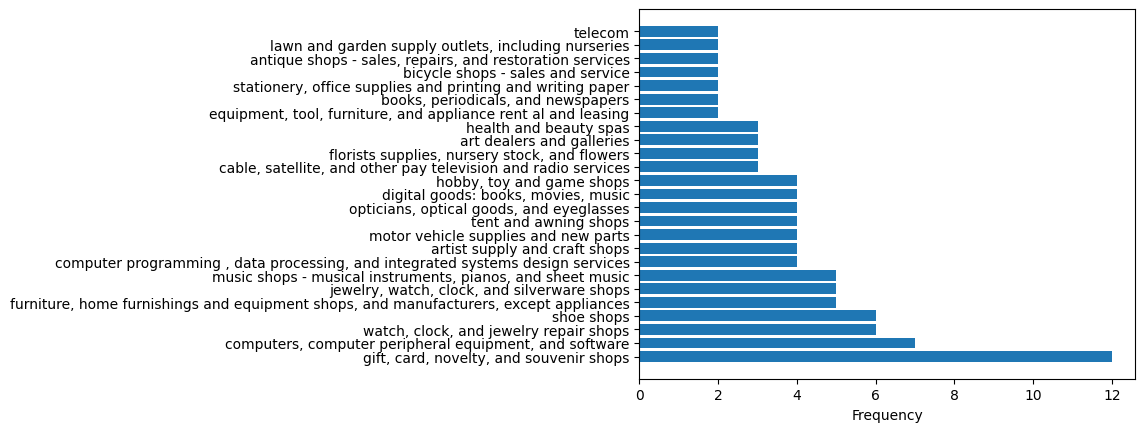

In [36]:
tags_count = top100.groupBy("tags") \
    .agg(
        count("merchant_abn").alias("count")
    ) \
    .orderBy(desc("count")) \
    .toPandas()

plt.barh(tags_count["tags"], tags_count["count"])
plt.xlabel("Frequency")

#### Segmented Ranking

Konw that we have 25 unique tags.

Assign tags to categories as follows:

**Hobbies: books, movies, music, and games**
- artist supply and craft shops
- books, periodicals, and newspapers
- digital goods: books, movies, music
- hobby, toy and game shops
- music shops - musical instruments, pianos, and sheet music

**Home and Office**
- cable, satellite, and other pay television and radio services
- computer programming , data processing, and integrated systems design services
- computers, computer peripheral equipment, and software
- equipment, tool, furniture, and appliance rent al and leasing
- furniture, home furnishings and equipment shops, and manufacturers, except appliances
- stationery, office supplies and printing and writing paper
- telecom

**Outdoors**
- bicycle shops - sales and service
- florists supplies, nursery stock, and flowers
- lawn and garden supply outlets, including nurseries
- motor vehicle supplies and new parts
- tent and awning shops

**Self-care and Fashion**
- health and beauty spas
- jewelry, watch, clock, and silverware shops
- opticians, optical goods, and eyeglasses
- shoe shops
- watch, clock, and jewelry repair shops

**Other**
- antique shops - sales, repairs, and restoration services
- art dealers and galleries
- gift, card, novelty, and souvenir shops

In [37]:
# store first word of every tag (know that each tag begins with a unique word)
segments_dic = {
    "Hobbies": ["artist", "books", "digital", "hobby", "music"],
    "Home and Office": ["cable", "computer", "computers", "equipment", "furniture", "stationery", "telecom"],
    "Outdoor": ["bicycle", "florists", "lawn", "motor", "tent"],
    "Self-care and Fashion": ["health", "jewelry", "opticians", "shoe", "watch"],
    "Other": ["antique", "art", "gift"]
}

In [38]:
# convert to dataframe so can iterate rows
merchants_df = top100.toPandas().set_index('merchant_abn')
merchants_df["segment"] = np.nan

Assign each merchant to a segment

In [39]:
for abn in merchants_df.index:
    tag = merchants_df._get_value(abn, "tags")
    first_word = tag.split(' ', 1)[0]
    first_word = re.sub(r'[^\w\s]', '', first_word)

    merch_segment = np.nan
    for segment, tags in segments_dic.items():
        if (first_word in tags):
            merch_segment = segment
    
    merchants_df.loc[abn, "segment"] = merch_segment

# remove merchant_abn as index col
merchants_df.reset_index(drop=False,inplace=True)

# convert back to spark dataframe
merchants_sdf = spark.createDataFrame(merchants_df)


Join merchants and rankings obtained previously

In [40]:
top100_seg = merchants_sdf.join(top100, "merchant_abn")
top100_seg.limit(5)

merchant_abn,company_name,tags,take_rate,revenue_band,total_points,pop_points,trans_points,profit_points,mcust_points,rank,segment,company_name,tags,take_rate,revenue_band,total_points,pop_points,trans_points,profit_points,mcust_points,rank
11215815177,Scelerisque Scele...,tent and awning s...,4.77,b,796652.5,0.0,367682.25,424727.625,4241.625,1,Outdoor,Scelerisque Scele...,tent and awning s...,4.77,b,796652.5,0.0,367682.25,424727.625,4241.625,1
11237511112,Magna Institute,"opticians, optica...",2.11,c,796632.0,0.125,367879.875,422894.25,5856.75,2,Self-care and Fas...,Magna Institute,"opticians, optica...",2.11,c,796632.0,0.125,367879.875,422894.25,5856.75,2
11243046390,Ornare Placerat F...,"books, periodical...",1.94,c,794245.125,0.125,368107.125,423107.25,3029.625,3,Hobbies,Ornare Placerat F...,"books, periodical...",1.94,c,794245.125,0.125,368107.125,423107.25,3029.625,3
11208869091,Cursus Et Eros LLP,"hobby, toy and ga...",6.48,a,794125.25,0.0,367653.75,424771.5,1699.0,4,Hobbies,Cursus Et Eros LLP,"hobby, toy and ga...",6.48,a,794125.25,0.0,367653.75,424771.5,1699.0,4
11121775571,Egestas Nunc Asso...,digital goods: bo...,6.58,a,778330.875,0.0,366961.5,405528.375,5840.0,5,Hobbies,Egestas Nunc Asso...,digital goods: bo...,6.58,a,778330.875,0.0,366961.5,405528.375,5840.0,5


In [ ]:
w = Window.partitionBy(top100_seg['segment']).orderBy(top100_seg['total_points'].desc())

seg_ranks = top100_seg \
    .select('*', rank().over(w).alias('rank')) \
    .filter(col('rank') <= 10)

print(seg_ranks.count())
print(seg_ranks.limit(20))

AnalysisException: Reference 'total_points' is ambiguous, could be: total_points, total_points.

Observe frequency of tags for each segment

In [ ]:
seg_ranks_df = seg_ranks.toPandas()
seg_ranks_grp = seg_ranks_df.groupby(["segment"])

i = 0
for segment in segments_dic.keys():
    top10 = seg_ranks_grp.get_group(segment)
    tags_count = dict(Counter(top10["tags"]))
    print(tags_count)

    plt.figure(i)
    plt.title(segment)
    plt.barh(list(tags_count.keys()), list(tags_count.values()))
    #plt.hist(top10["tags"], orientation='horizontal')

    i += 1
